# Generative Adversarial Networks (GANs)

## What are GANs?

Generative Adversarial Networks (GANs) are a class of machine learning frameworks where two neural networks compete against each other in a game-theoretic scenario. GANs have revolutionized generative modeling and are capable of producing highly realistic synthetic data.

### Key Components:

1. **Generator (G)**: Creates fake data from random noise
2. **Discriminator (D)**: Distinguishes between real and fake data
3. **Adversarial Training**: The two networks compete in a minimax game

### The Minimax Game:

$$\min_G \max_D V(D,G) = \mathbb{E}_{x \sim p_{data}(x)}[\log D(x)] + \mathbb{E}_{z \sim p_z(z)}[\log(1 - D(G(z)))]$$

- **Discriminator**: Maximizes ability to distinguish real from fake
- **Generator**: Minimizes discriminator's ability to detect fakes

### Applications:
- Image generation and editing
- Style transfer
- Data augmentation
- Super-resolution
- Text-to-image synthesis

In this tutorial, we'll implement various GAN architectures using MNIST and explore their capabilities.

In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Try to import matplotlib animation - some environments may not support it
try:
    import matplotlib.animation as animation
    from IPython.display import HTML
    ANIMATION_AVAILABLE = True
except ImportError:
    print("Warning: matplotlib.animation not available - some visualizations may not work")
    ANIMATION_AVAILABLE = False

# Set random seed for reproducibility
manualSeed = 42
np.random.seed(manualSeed)
torch.manual_seed(manualSeed)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


## Loading and Preprocessing Data

Dataset size: 60000
Number of batches: 469
Image shape: torch.Size([1, 28, 28])


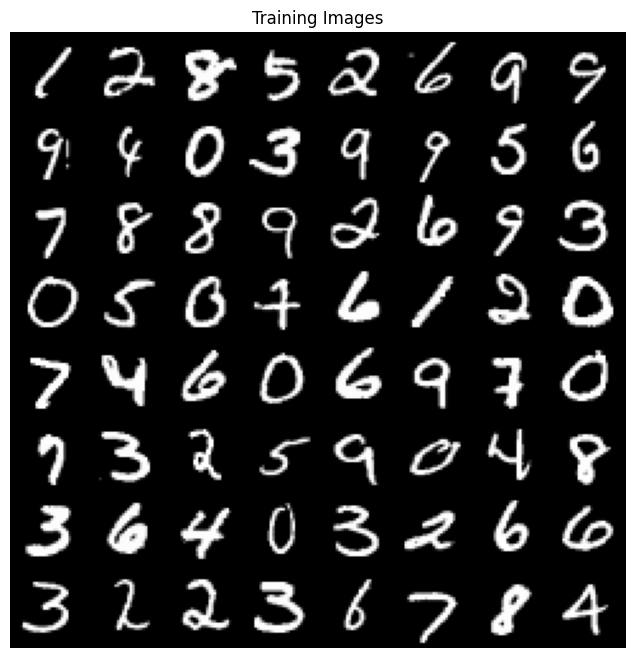

In [2]:
# Data transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Load MNIST dataset
dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                    download=True, transform=transform)

# Create data loader
batch_size = 128
# Set num_workers=0 for compatibility across platforms
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

print(f'Dataset size: {len(dataset)}')
print(f'Number of batches: {len(dataloader)}')
print(f'Image shape: {dataset[0][0].shape}')

# Visualize some real images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:64], padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.show()

## Building a Basic GAN

Let's start with a simple fully-connected GAN

In [3]:
# Generator Network
class Generator(nn.Module):
    def __init__(self, noise_dim=100, hidden_dim=256, output_dim=784):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # First layer
            nn.Linear(noise_dim, hidden_dim),
            nn.ReLU(True),
            
            # Second layer
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.BatchNorm1d(hidden_dim * 2),
            nn.ReLU(True),
            
            # Third layer
            nn.Linear(hidden_dim * 2, hidden_dim * 4),
            nn.BatchNorm1d(hidden_dim * 4),
            nn.ReLU(True),
            
            # Output layer
            nn.Linear(hidden_dim * 4, output_dim),
            nn.Tanh()  # Output in [-1, 1]
        )
    
    def forward(self, input):
        return self.main(input)

# Discriminator Network
class Discriminator(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=256):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # First layer
            nn.Linear(input_dim, hidden_dim * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            
            # Second layer
            nn.Linear(hidden_dim * 4, hidden_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            
            # Third layer
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            
            # Output layer
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()  # Output probability
        )
    
    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

# Initialize networks
noise_dim = 100
netG = Generator(noise_dim).to(device)
netD = Discriminator().to(device)

print("Generator:")
print(netG)
print(f"\nGenerator parameters: {sum(p.numel() for p in netG.parameters()):,}")

print("\nDiscriminator:")
print(netD)
print(f"\nDiscriminator parameters: {sum(p.numel() for p in netD.parameters()):,}")

Generator:
Generator(
  (main): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): Linear(in_features=512, out_features=1024, bias=True)
    (6): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): Linear(in_features=1024, out_features=784, bias=True)
    (9): Tanh()
  )
)

Generator parameters: 1,489,424

Discriminator:
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_feat

## Understanding GAN Training Dynamics

GAN training is notoriously challenging. Let's visualize the training process:

In [4]:
# Initialize weights
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

netG.apply(weights_init)
netD.apply(weights_init)

# Loss function
criterion = nn.BCELoss()

# Create batch of latent vectors for visualization
fixed_noise = torch.randn(64, noise_dim, device=device)

# Labels
real_label = 1.
fake_label = 0.

# Optimizers
lr = 0.0002
beta1 = 0.5
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

print("Starting Training Loop...")

Starting Training Loop...


## Training the GAN

In [5]:
# Training Loop
num_epochs = 20
G_losses = []
D_losses = []
img_list = []
iters = 0

print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, data in enumerate(tqdm(dataloader, desc=f'Epoch {epoch+1}/{num_epochs}')):
        
        ############################
        # (1) Update Discriminator: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        
        # Train with real data
        netD.zero_grad()
        real_data = data[0].to(device)
        batch_size = real_data.size(0)
        labels = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
        
        # Forward pass real batch through D
        real_data_flat = real_data.view(batch_size, -1)
        output = netD(real_data_flat)
        errD_real = criterion(output, labels)
        errD_real.backward()
        D_x = output.mean().item()
        
        # Train with fake data
        noise = torch.randn(batch_size, noise_dim, device=device)
        fake = netG(noise)
        labels.fill_(fake_label)
        
        # Forward pass fake batch through D
        output = netD(fake.detach())
        errD_fake = criterion(output, labels)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        
        # Update D
        errD = errD_real + errD_fake
        optimizerD.step()
        
        ############################
        # (2) Update Generator: maximize log(D(G(z)))
        ###########################
        
        netG.zero_grad()
        labels.fill_(real_label)  # Fake labels are real for generator cost
        
        # Forward pass fake batch through D again
        output = netD(fake)
        errG = criterion(output, labels)
        errG.backward()
        D_G_z2 = output.mean().item()
        
        # Update G
        optimizerG.step()
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
                img_list.append(vutils.make_grid(fake.view(-1, 1, 28, 28), padding=2, normalize=True))
        
        iters += 1
    
    # Print statistics
    print(f'[{epoch+1}/{num_epochs}] Loss_D: {errD.item():.4f} Loss_G: {errG.item():.4f} '
          f'D(x): {D_x:.4f} D(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}')

print("Training completed!")

Starting Training Loop...


Epoch 1/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:08<00:00, 56.59it/s]


[1/20] Loss_D: 1.2922 Loss_G: 1.6613 D(x): 0.7775 D(G(z)): 0.6330 / 0.1976


Epoch 2/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:08<00:00, 54.30it/s]


[2/20] Loss_D: 1.1405 Loss_G: 1.0270 D(x): 0.4646 D(G(z)): 0.2372 / 0.3758


Epoch 3/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:08<00:00, 53.71it/s]


[3/20] Loss_D: 1.1224 Loss_G: 1.3014 D(x): 0.5989 D(G(z)): 0.3947 / 0.2936


Epoch 4/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:08<00:00, 52.15it/s]


[4/20] Loss_D: 1.0945 Loss_G: 0.9387 D(x): 0.5556 D(G(z)): 0.3310 / 0.4147


Epoch 5/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:09<00:00, 49.17it/s]


[5/20] Loss_D: 1.1486 Loss_G: 1.0124 D(x): 0.5764 D(G(z)): 0.3850 / 0.3808


Epoch 6/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:08<00:00, 53.77it/s]


[6/20] Loss_D: 1.2016 Loss_G: 0.8163 D(x): 0.4706 D(G(z)): 0.3264 / 0.4584


Epoch 7/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:08<00:00, 56.74it/s]


[7/20] Loss_D: 1.1305 Loss_G: 1.3414 D(x): 0.6755 D(G(z)): 0.4899 / 0.2698


Epoch 8/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:09<00:00, 50.90it/s]


[8/20] Loss_D: 1.3099 Loss_G: 1.0591 D(x): 0.5671 D(G(z)): 0.4672 / 0.3631


Epoch 9/20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:09<00:00, 49.29it/s]


[9/20] Loss_D: 1.1821 Loss_G: 0.8828 D(x): 0.6191 D(G(z)): 0.4644 / 0.4328


Epoch 10/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:08<00:00, 55.97it/s]


[10/20] Loss_D: 1.3527 Loss_G: 0.9710 D(x): 0.5217 D(G(z)): 0.4569 / 0.3919


Epoch 11/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:09<00:00, 51.18it/s]


[11/20] Loss_D: 1.2761 Loss_G: 0.9042 D(x): 0.5846 D(G(z)): 0.4874 / 0.4257


Epoch 12/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:09<00:00, 50.26it/s]


[12/20] Loss_D: 1.3350 Loss_G: 0.9254 D(x): 0.5308 D(G(z)): 0.4849 / 0.4071


Epoch 13/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:08<00:00, 54.89it/s]


[13/20] Loss_D: 1.2593 Loss_G: 0.8620 D(x): 0.5606 D(G(z)): 0.4592 / 0.4374


Epoch 14/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:08<00:00, 54.12it/s]


[14/20] Loss_D: 1.2900 Loss_G: 0.8252 D(x): 0.5088 D(G(z)): 0.4350 / 0.4503


Epoch 15/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:08<00:00, 52.76it/s]


[15/20] Loss_D: 1.3506 Loss_G: 0.8288 D(x): 0.4965 D(G(z)): 0.4570 / 0.4466


Epoch 16/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:08<00:00, 56.29it/s]


[16/20] Loss_D: 1.3783 Loss_G: 0.7790 D(x): 0.4954 D(G(z)): 0.4683 / 0.4669


Epoch 17/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:09<00:00, 48.36it/s]


[17/20] Loss_D: 1.3688 Loss_G: 0.8317 D(x): 0.5378 D(G(z)): 0.4994 / 0.4440


Epoch 18/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:08<00:00, 53.00it/s]


[18/20] Loss_D: 1.3673 Loss_G: 0.8290 D(x): 0.5295 D(G(z)): 0.5033 / 0.4415


Epoch 19/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:08<00:00, 55.73it/s]


[19/20] Loss_D: 1.3612 Loss_G: 0.7952 D(x): 0.5286 D(G(z)): 0.5034 / 0.4560


Epoch 20/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:08<00:00, 55.69it/s]

[20/20] Loss_D: 1.3828 Loss_G: 0.8101 D(x): 0.5275 D(G(z)): 0.5067 / 0.4528
Training completed!


## Analyzing Training Progress

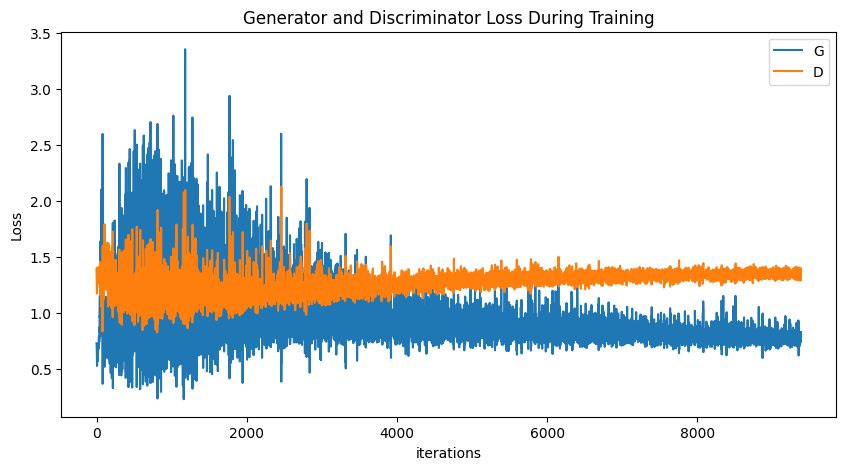

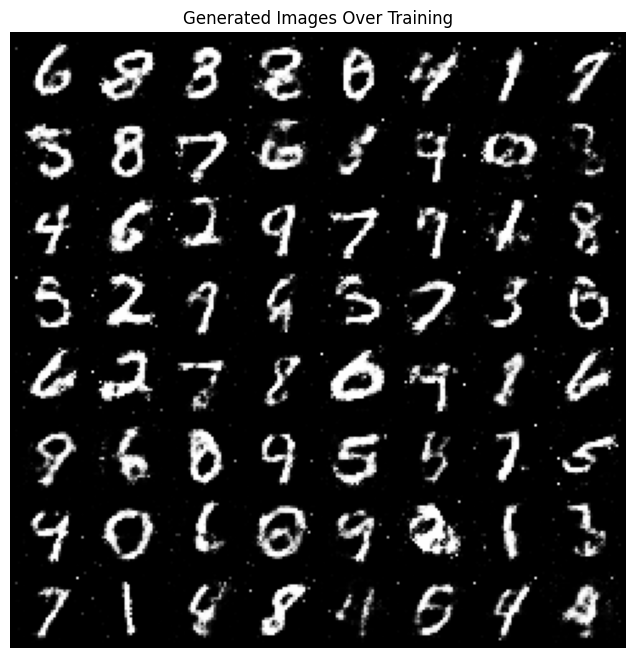

In [6]:
# Plot training losses
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Show progression of generated images
if ANIMATION_AVAILABLE and len(img_list) > 0:
    fig = plt.figure(figsize=(8, 8))
    plt.axis("off")
    try:
        ims = [[plt.imshow(np.transpose(i, (1, 2, 0)), animated=True)] for i in img_list]
        plt.title("Generated Images Over Training")
        plt.imshow(np.transpose(img_list[-1], (1, 2, 0)))
    except:
        # Fallback to just showing the final image
        plt.title("Final Generated Images")
        plt.imshow(np.transpose(img_list[-1], (1, 2, 0)))
    plt.show()
else:
    # Just show the final generated images
    if len(img_list) > 0:
        plt.figure(figsize=(8, 8))
        plt.axis("off")
        plt.title("Final Generated Images")
        plt.imshow(np.transpose(img_list[-1], (1, 2, 0)))
        plt.show()
    else:
        print("No generated images to display")

## Comparing Real vs Generated Images

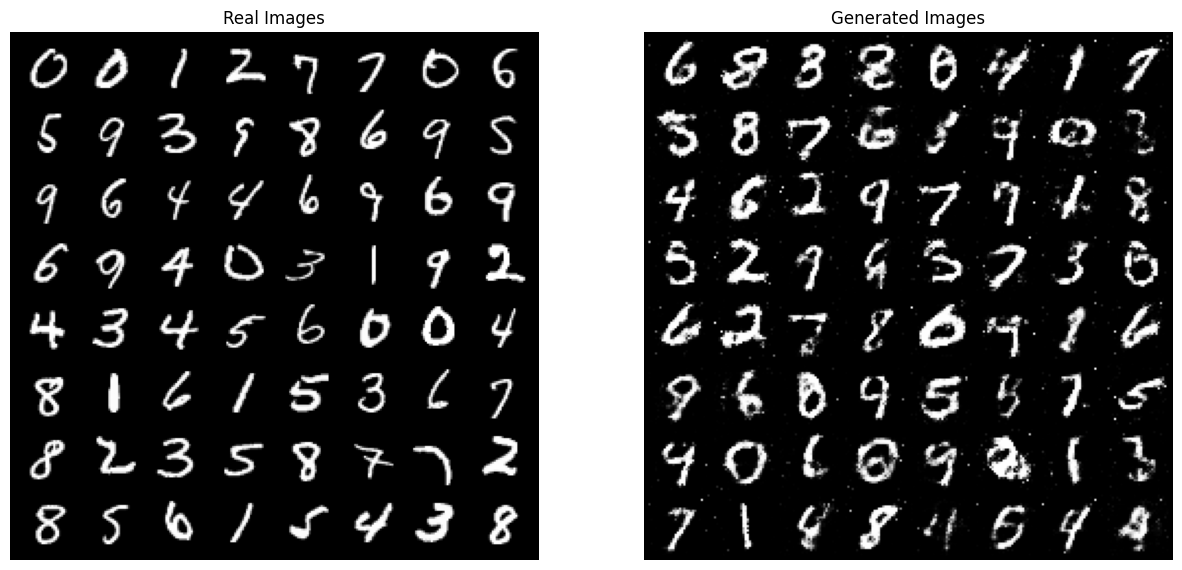

In [7]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:64], padding=5, normalize=True).cpu(), (1, 2, 0)))

# Plot the fake images from the last epoch
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(img_list[-1], (1, 2, 0)))
plt.show()

## Deep Convolutional GAN (DCGAN)

Let's implement a more sophisticated CNN-based GAN

## Conditional GAN (cGAN)

Conditional GANs allow us to control the generation process by conditioning on labels

In [11]:
class ConditionalGenerator(nn.Module):
    def __init__(self, noise_dim=100, label_dim=10, hidden_dim=256, output_dim=784):
        super(ConditionalGenerator, self).__init__()
        
        # Label embedding
        self.label_emb = nn.Embedding(label_dim, label_dim)
        
        self.main = nn.Sequential(
            nn.Linear(noise_dim + label_dim, hidden_dim),
            nn.ReLU(True),
            
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.BatchNorm1d(hidden_dim * 2),
            nn.ReLU(True),
            
            nn.Linear(hidden_dim * 2, hidden_dim * 4),
            nn.BatchNorm1d(hidden_dim * 4),
            nn.ReLU(True),
            
            nn.Linear(hidden_dim * 4, output_dim),
            nn.Tanh()
        )
    
    def forward(self, noise, labels):
        # Embed labels
        c = self.label_emb(labels)
        # Concatenate noise and label
        x = torch.cat([noise, c], 1)
        return self.main(x)

class ConditionalDiscriminator(nn.Module):
    def __init__(self, input_dim=784, label_dim=10, hidden_dim=256):
        super(ConditionalDiscriminator, self).__init__()
        
        # Label embedding
        self.label_emb = nn.Embedding(label_dim, label_dim)
        
        self.main = nn.Sequential(
            nn.Linear(input_dim + label_dim, hidden_dim * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            
            nn.Linear(hidden_dim * 4, hidden_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
    
    def forward(self, input, labels):
        # Embed labels
        c = self.label_emb(labels)
        # Concatenate input and label
        x = torch.cat([input, c], 1)
        return self.main(x).view(-1)

# Create conditional GAN
cgan_G = ConditionalGenerator().to(device)
cgan_D = ConditionalDiscriminator().to(device)

cgan_G.apply(weights_init)
cgan_D.apply(weights_init)

print(f"Conditional Generator parameters: {sum(p.numel() for p in cgan_G.parameters()):,}")
print(f"Conditional Discriminator parameters: {sum(p.numel() for p in cgan_D.parameters()):,}")

Conditional Generator parameters: 1,492,084
Conditional Discriminator parameters: 1,470,565


In [12]:
# Train Conditional GAN
def train_cgan(generator, discriminator, dataloader, num_epochs=10):
    criterion = nn.BCELoss()
    optimizerD = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizerG = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    
    G_losses = []
    D_losses = []
    
    for epoch in range(num_epochs):
        for i, (data, labels) in enumerate(tqdm(dataloader, desc=f'cGAN Epoch {epoch+1}/{num_epochs}')):
            
            # Prepare data
            real_data = data.to(device).view(data.size(0), -1)
            real_labels = labels.to(device)
            batch_size = real_data.size(0)
            
            # Update Discriminator
            discriminator.zero_grad()
            
            # Train with real
            d_labels = torch.full((batch_size,), 1., dtype=torch.float, device=device)
            output = discriminator(real_data, real_labels)
            errD_real = criterion(output, d_labels)
            errD_real.backward()
            
            # Train with fake
            noise = torch.randn(batch_size, 100, device=device)
            fake_labels = torch.randint(0, 10, (batch_size,), device=device)
            fake = generator(noise, fake_labels)
            d_labels.fill_(0.)
            output = discriminator(fake.detach(), fake_labels)
            errD_fake = criterion(output, d_labels)
            errD_fake.backward()
            optimizerD.step()
            
            # Update Generator
            generator.zero_grad()
            d_labels.fill_(1.)
            output = discriminator(fake, fake_labels)
            errG = criterion(output, d_labels)
            errG.backward()
            optimizerG.step()
            
            G_losses.append(errG.item())
            D_losses.append((errD_real + errD_fake).item())
        
        print(f'Epoch [{epoch+1}/{num_epochs}] Loss_D: {(errD_real + errD_fake).item():.4f} Loss_G: {errG.item():.4f}')
    
    return G_losses, D_losses

print("Training Conditional GAN...")
cgan_G_losses, cgan_D_losses = train_cgan(cgan_G, cgan_D, dataloader, num_epochs=10)

Training Conditional GAN...


cGAN Epoch 1/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:08<00:00, 54.99it/s]


Epoch [1/10] Loss_D: 1.2308 Loss_G: 1.0562


cGAN Epoch 2/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:08<00:00, 56.65it/s]


Epoch [2/10] Loss_D: 0.9337 Loss_G: 1.4506


cGAN Epoch 3/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:08<00:00, 56.89it/s]


Epoch [3/10] Loss_D: 1.1023 Loss_G: 1.1885


cGAN Epoch 4/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:08<00:00, 56.18it/s]


Epoch [4/10] Loss_D: 1.0580 Loss_G: 0.9891


cGAN Epoch 5/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:08<00:00, 55.10it/s]


Epoch [5/10] Loss_D: 1.1547 Loss_G: 1.3307


cGAN Epoch 6/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:08<00:00, 52.91it/s]


Epoch [6/10] Loss_D: 1.2069 Loss_G: 0.9945


cGAN Epoch 7/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:08<00:00, 54.26it/s]


Epoch [7/10] Loss_D: 1.1568 Loss_G: 0.8932


cGAN Epoch 8/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:11<00:00, 41.17it/s]


Epoch [8/10] Loss_D: 1.2000 Loss_G: 0.8895


cGAN Epoch 9/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:10<00:00, 46.14it/s]


Epoch [9/10] Loss_D: 1.2667 Loss_G: 0.8419


cGAN Epoch 10/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:08<00:00, 52.43it/s]

Epoch [10/10] Loss_D: 1.2439 Loss_G: 0.7681


## Generating Specific Digits with cGAN

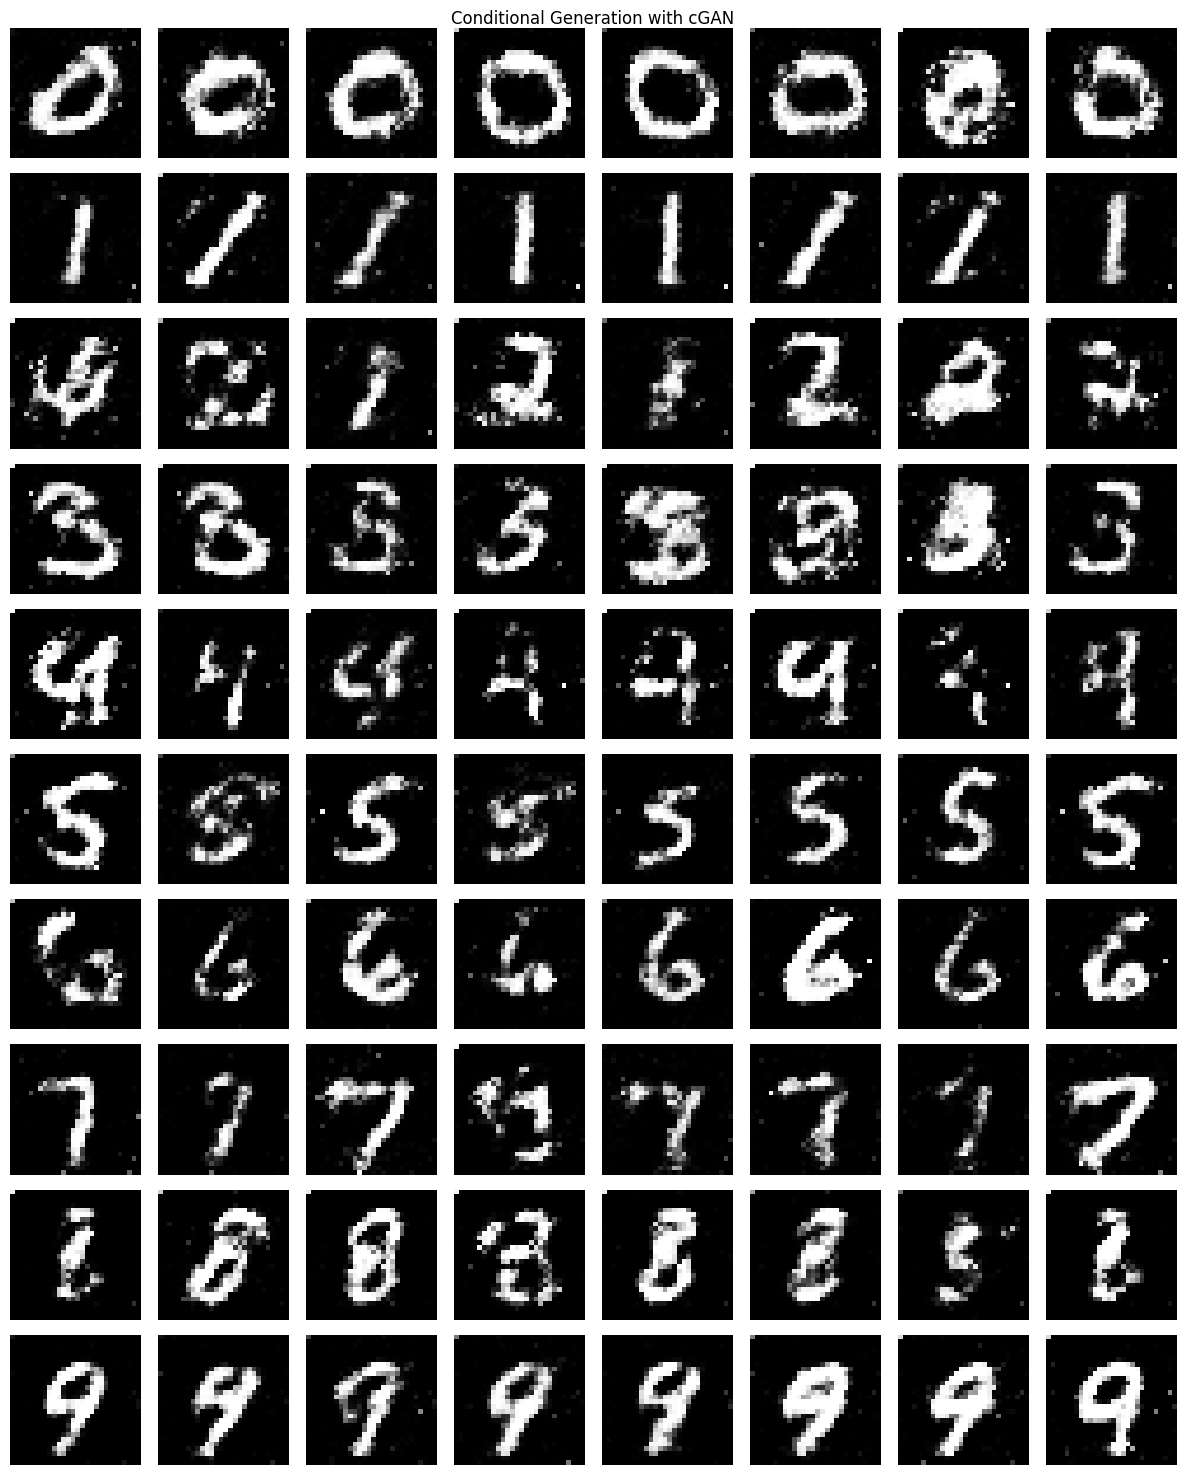

In [13]:
def generate_digits_cgan(generator, digits, n_samples=5):
    """Generate specific digits using conditional GAN"""
    generator.eval()
    
    fig, axes = plt.subplots(len(digits), n_samples, figsize=(n_samples*1.5, len(digits)*1.5))
    
    with torch.no_grad():
        for i, digit in enumerate(digits):
            # Create noise and labels
            noise = torch.randn(n_samples, 100, device=device)
            labels = torch.full((n_samples,), digit, dtype=torch.long, device=device)
            
            # Generate
            samples = generator(noise, labels)
            samples = samples.view(-1, 28, 28)
            
            # Plot
            for j in range(n_samples):
                ax = axes[i, j] if len(digits) > 1 else axes[j]
                ax.imshow(samples[j].cpu(), cmap='gray')
                ax.axis('off')
                if j == 0:
                    ax.set_ylabel(f'Digit {digit}', rotation=90, size='large')
    
    plt.suptitle('Conditional Generation with cGAN')
    plt.tight_layout()
    plt.show()

# Generate specific digits
generate_digits_cgan(cgan_G, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], n_samples=8)

## Wasserstein GAN (WGAN)

WGAN addresses training instability by using the Wasserstein distance

In [22]:
class WGANCritic(nn.Module):
    """WGAN Critic (replaces discriminator)"""
    def __init__(self, input_dim=784, hidden_dim=256):
        super(WGANCritic, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(input_dim, hidden_dim * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Linear(hidden_dim * 4, hidden_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Linear(hidden_dim, 1)
            # No sigmoid! WGAN critic outputs unbounded values
        )
    
    def forward(self, input):
        return self.main(input).view(-1)

# WGAN Generator (same as basic GAN)
wgan_G = Generator().to(device)
wgan_C = WGANCritic().to(device)

wgan_G.apply(weights_init)
wgan_C.apply(weights_init)

def train_wgan(generator, critic, dataloader, num_epochs=10, clip_value=0.01, n_critic=5):
    """Train WGAN with weight clipping"""
    optimizerC = optim.RMSprop(critic.parameters(), lr=0.00005)
    optimizerG = optim.RMSprop(generator.parameters(), lr=0.00005)
    
    G_losses = []
    C_losses = []
    
    for epoch in range(num_epochs):
        for i, (data, _) in enumerate(tqdm(dataloader, desc=f'WGAN Epoch {epoch+1}/{num_epochs}')):
            
            real_data = data.to(device).view(data.size(0), -1)
            batch_size = real_data.size(0)
            
            # Update Critic
            for _ in range(n_critic):
                critic.zero_grad()
                
                # Train with real
                critic_real = critic(real_data).mean()
                
                # Train with fake
                noise = torch.randn(batch_size, 100, device=device)
                fake = generator(noise)
                critic_fake = critic(fake.detach()).mean()
                
                # WGAN loss
                critic_loss = critic_fake - critic_real
                critic_loss.backward()
                optimizerC.step()
                
                # Clip weights
                for p in critic.parameters():
                    p.data.clamp_(-clip_value, clip_value)
            
            # Update Generator
            generator.zero_grad()
            gen_loss = -critic(fake).mean()
            gen_loss.backward()
            optimizerG.step()
            
            G_losses.append(gen_loss.item())
            C_losses.append(critic_loss.item())
        
        print(f'Epoch [{epoch+1}/{num_epochs}] Loss_C: {critic_loss.item():.4f} Loss_G: {gen_loss.item():.4f}')
    
    return G_losses, C_losses

print("Training WGAN...")
wgan_G_losses, wgan_C_losses = train_wgan(wgan_G, wgan_C, dataloader, num_epochs=15)

Training WGAN...


WGAN Epoch 1/15: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:16<00:00, 27.86it/s]


Epoch [1/15] Loss_C: -0.1449 Loss_G: -47.9055


WGAN Epoch 2/15: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:17<00:00, 26.77it/s]


Epoch [2/15] Loss_C: -0.1451 Loss_G: -22.3447


WGAN Epoch 3/15: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:18<00:00, 25.63it/s]


Epoch [3/15] Loss_C: -0.7182 Loss_G: -14.7925


WGAN Epoch 4/15: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:17<00:00, 27.12it/s]


Epoch [4/15] Loss_C: -0.5543 Loss_G: -9.4604


WGAN Epoch 5/15: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:17<00:00, 27.12it/s]


Epoch [5/15] Loss_C: -0.8472 Loss_G: -3.0787


WGAN Epoch 6/15: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:17<00:00, 27.18it/s]


Epoch [6/15] Loss_C: -1.7201 Loss_G: 0.6984


WGAN Epoch 7/15: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:17<00:00, 26.56it/s]


Epoch [7/15] Loss_C: -1.8254 Loss_G: -12.1290


WGAN Epoch 8/15: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:17<00:00, 26.77it/s]


Epoch [8/15] Loss_C: -1.3829 Loss_G: -1.9918


WGAN Epoch 9/15: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:17<00:00, 26.72it/s]


Epoch [9/15] Loss_C: -1.2787 Loss_G: -3.1500


WGAN Epoch 10/15: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:17<00:00, 26.46it/s]


Epoch [10/15] Loss_C: -1.2395 Loss_G: -6.9558


WGAN Epoch 11/15: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:16<00:00, 27.60it/s]


Epoch [11/15] Loss_C: -1.0113 Loss_G: -4.3943


WGAN Epoch 12/15: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:21<00:00, 22.02it/s]


Epoch [12/15] Loss_C: -1.0675 Loss_G: 1.6453


WGAN Epoch 13/15: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:18<00:00, 25.34it/s]


Epoch [13/15] Loss_C: -0.9528 Loss_G: -0.6659


WGAN Epoch 14/15: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:17<00:00, 26.13it/s]


Epoch [14/15] Loss_C: -0.6990 Loss_G: -0.2467


WGAN Epoch 15/15: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:19<00:00, 24.18it/s]

Epoch [15/15] Loss_C: -0.7785 Loss_G: 6.6021


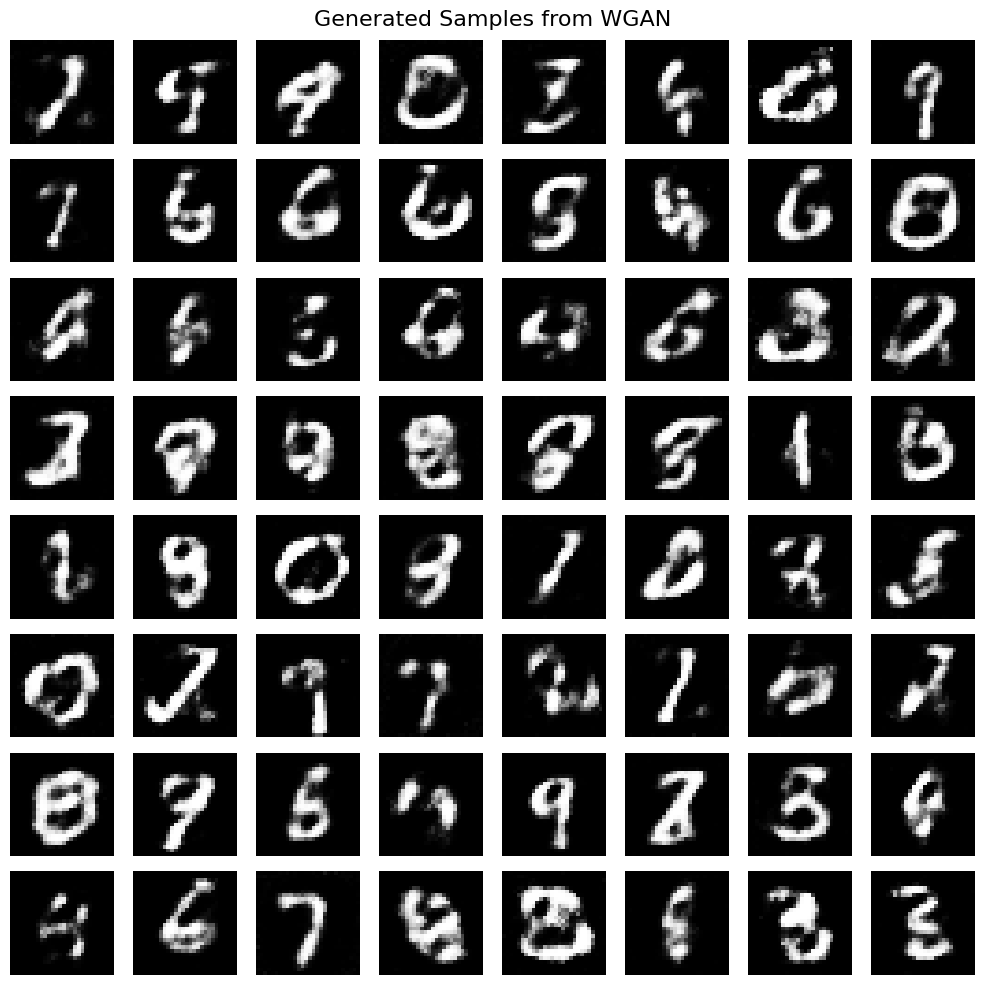

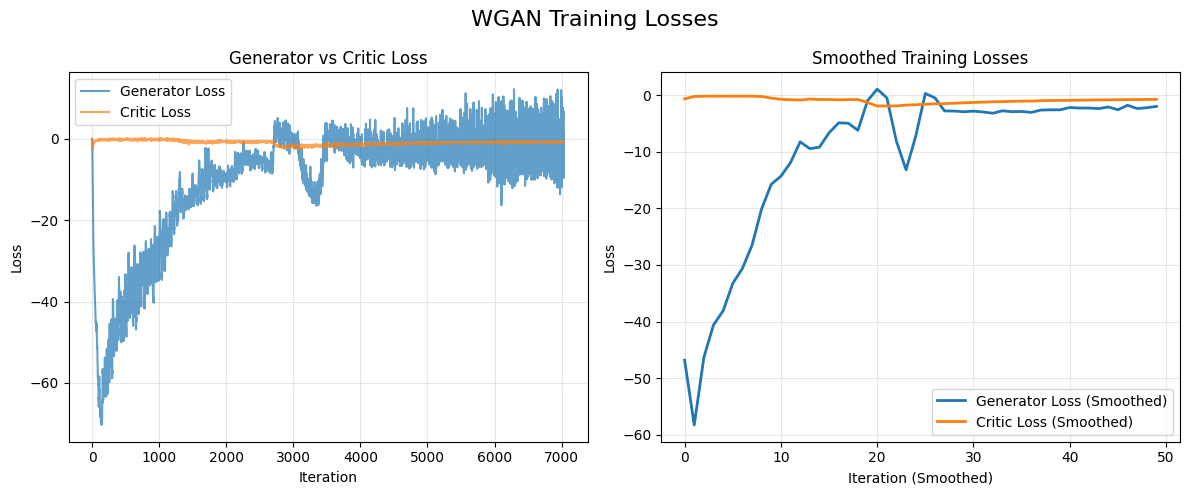

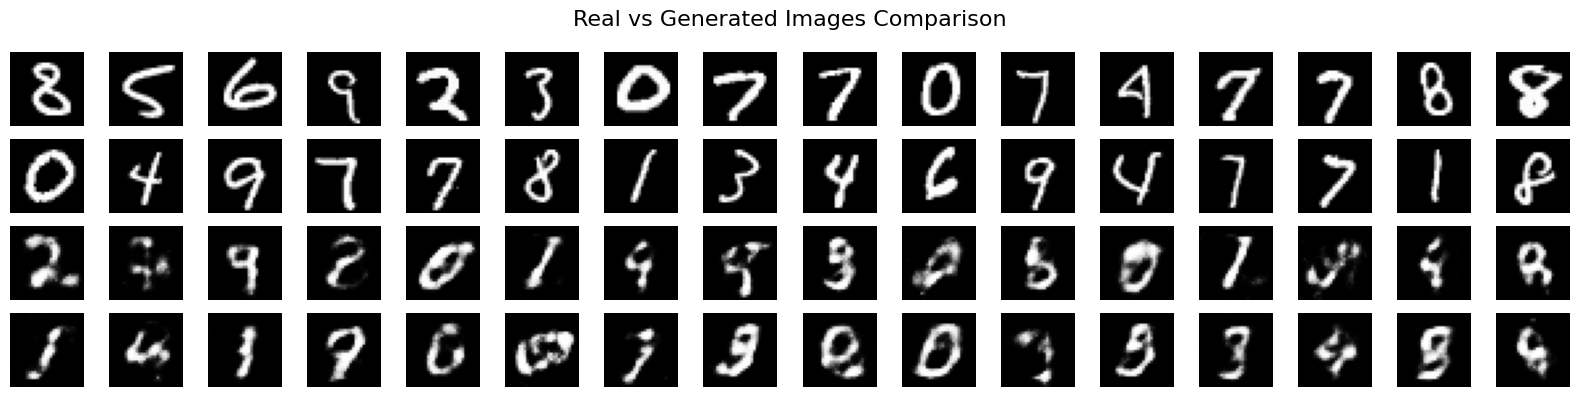

In [23]:
import matplotlib.pyplot as plt
import torch

def generate_samples_wgan(generator, n_samples=64, nrows=8, ncols=8, figsize=(10, 10)):
    """Generate random samples using WGAN generator"""
    generator.eval()
    
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()
    
    with torch.no_grad():
        # Generate noise
        noise = torch.randn(n_samples, 100, device=device)
        
        # Generate samples
        samples = generator(noise)
        samples = samples.view(-1, 28, 28)  # Assuming MNIST format
        
        # Plot samples
        for i in range(min(n_samples, len(axes))):
            axes[i].imshow(samples[i].cpu(), cmap='gray')
            axes[i].axis('off')
        
        # Hide any unused subplots
        for i in range(n_samples, len(axes)):
            axes[i].axis('off')
    
    plt.suptitle('Generated Samples from WGAN', fontsize=16)
    plt.tight_layout()
    plt.show()

def plot_wgan_losses(G_losses, C_losses, title="WGAN Training Losses"):
    """Plot generator and critic losses"""
    plt.figure(figsize=(12, 5))
    
    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(G_losses, label='Generator Loss', alpha=0.7)
    plt.plot(C_losses, label='Critic Loss', alpha=0.7)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Generator vs Critic Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot smoothed losses
    plt.subplot(1, 2, 2)
    # Simple moving average for smoothing
    window_size = len(G_losses) // 50 if len(G_losses) > 50 else 1
    if window_size > 1:
        G_smooth = [sum(G_losses[i:i+window_size])/window_size 
                   for i in range(0, len(G_losses)-window_size, window_size)]
        C_smooth = [sum(C_losses[i:i+window_size])/window_size 
                   for i in range(0, len(C_losses)-window_size, window_size)]
        plt.plot(G_smooth, label='Generator Loss (Smoothed)', linewidth=2)
        plt.plot(C_smooth, label='Critic Loss (Smoothed)', linewidth=2)
    else:
        plt.plot(G_losses, label='Generator Loss')
        plt.plot(C_losses, label='Critic Loss')
    
    plt.xlabel('Iteration (Smoothed)')
    plt.ylabel('Loss')
    plt.title('Smoothed Training Losses')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

def compare_real_vs_generated(generator, dataloader, n_samples=32):
    """Compare real images vs generated images side by side"""
    generator.eval()
    
    # Get real samples
    real_batch = next(iter(dataloader))[0][:n_samples]
    real_images = real_batch.view(-1, 28, 28)
    
    # Generate fake samples
    with torch.no_grad():
        noise = torch.randn(n_samples, 100, device=device)
        fake_images = generator(noise).view(-1, 28, 28)
    
    # Plot comparison
    fig, axes = plt.subplots(4, 16, figsize=(16, 4))
    
    # Plot real images in first two rows
    for i in range(16):
        axes[0, i].imshow(real_images[i].cpu(), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(real_images[i+16].cpu(), cmap='gray')
        axes[1, i].axis('off')
    
    # Plot generated images in last two rows
    for i in range(16):
        axes[2, i].imshow(fake_images[i].cpu(), cmap='gray')
        axes[2, i].axis('off')
        axes[3, i].imshow(fake_images[i+16].cpu(), cmap='gray')
        axes[3, i].axis('off')
    
    # Add labels
    axes[0, 0].set_ylabel('Real\nSamples', rotation=0, size='large', ha='right')
    axes[2, 0].set_ylabel('Generated\nSamples', rotation=0, size='large', ha='right')
    
    plt.suptitle('Real vs Generated Images Comparison', fontsize=16)
    plt.tight_layout()
    plt.show()

# Generate and display random samples
generate_samples_wgan(wgan_G, n_samples=64)

# Plot training losses
plot_wgan_losses(wgan_G_losses, wgan_C_losses)

# Compare real vs generated
compare_real_vs_generated(wgan_G, dataloader)

## Exercises

Now it's your turn to experiment with GANs! Try these exercises:

### Exercise 1: Implement Progressive GAN
Build a GAN that starts with low resolution and progressively increases

In [16]:
# Exercise 1: Progressive GAN
class ProgressiveGenerator(nn.Module):
    def __init__(self, max_resolution=28):
        super(ProgressiveGenerator, self).__init__()
        # TODO: Implement progressive layers
        # Start with 4x4, then 8x8, 16x16, 28x28
        # Use fade-in mechanism between stages
        pass
    
    def forward(self, x, stage=0, alpha=1.0):
        # TODO: Implement progressive forward pass
        # alpha controls the fade-in between stages
        pass

# Implement training loop with progressive stages

### Exercise 2: Implement CycleGAN
Build a GAN that can translate between two domains without paired data

In [17]:
# Exercise 2: CycleGAN
class CycleGAN(nn.Module):
    def __init__(self):
        super(CycleGAN, self).__init__()
        # TODO: Implement two generators (A->B and B->A)
        # TODO: Implement two discriminators (for A and B)
        pass
    
    def cycle_consistency_loss(self, real_A, real_B, lambda_cycle=10.0):
        """
        Implement cycle consistency loss:
        L_cyc = ||G_BA(G_AB(A)) - A|| + ||G_AB(G_BA(B)) - B||
        """
        # TODO: Implement cycle consistency
        pass

# Try on MNIST vs Fashion-MNIST

### Exercise 3: Implement Spectral Normalization
Add spectral normalization to improve training stability

In [18]:
# Exercise 3: Spectral Normalization
class SpectralNorm(nn.Module):
    def __init__(self, module, name='weight', power_iterations=1):
        super(SpectralNorm, self).__init__()
        # TODO: Implement spectral normalization
        # Normalize weights by their spectral norm (largest singular value)
        pass
    
    def forward(self, input):
        # TODO: Apply spectral normalization before forward pass
        pass

def spectral_norm(module, name='weight', power_iterations=1):
    """Apply spectral normalization to a module"""
    # TODO: Wrapper function for easy application
    pass

# Apply to discriminator and compare training stability

### Exercise 4: Implement Self-Attention GAN (SAGAN)
Add self-attention mechanism to improve long-range dependencies

In [19]:
# Exercise 4: Self-Attention GAN
class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super(SelfAttention, self).__init__()
        # TODO: Implement self-attention mechanism
        # Query, Key, Value projections
        # Attention computation
        pass
    
    def forward(self, x):
        # TODO: Compute self-attention
        # x shape: (batch, channels, height, width)
        pass

class SAGANGenerator(nn.Module):
    def __init__(self):
        super(SAGANGenerator, self).__init__()
        # TODO: Integrate self-attention into generator
        pass

# Compare with regular DCGAN

## Summary

In this tutorial, we've covered:

1. **GAN Fundamentals**: Adversarial training between generator and discriminator
2. **Basic GAN**: Fully-connected implementation
3. **DCGAN**: Convolutional architecture for better image generation
4. **Conditional GAN**: Controlled generation with labels
5. **WGAN**: Improved training stability with Wasserstein distance
6. **Training Challenges**: Mode collapse, training instability

Key takeaways:
- GANs use adversarial training to learn data distributions
- Training can be unstable and requires careful tuning
- Different variants address specific issues (stability, control, quality)
- Architecture design significantly impacts generation quality

GANs have revolutionized generative modeling and continue to be an active area of research with applications in art, entertainment, and data augmentation!